Imports

In [51]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import percentileofscore

sys.path.insert(0, "..")
from utils import join_data, load_dataset
from utils import preprocess, get_sequence, generate_sampling_data, load_single_dataset, get_seq_len, get_deleted_sequence, calculate_direct_repeat
from utils import RESULTSPATH, SEGMENTS, SEGMENT_DICTS, ACCNUMDICT, DATAPATH, CMAP
plt.style.use("seaborn")
cm = plt.get_cmap(CMAP)

# remove warning in matplotlib because of bug when plot matrix
import warnings
import matplotlib    
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Load data

In [52]:
dfs = list()
dfnames = ["Alnaji2021", "Pelz2021", "Wang2023", "Wang2020", "Zhuravlev2020", "Kupke2020", "VdHoecke2015"]
strain = "PR8"
for dataset in dfnames:
    df = join_data(load_dataset(dataset))
    dfs.append(preprocess(strain, df, 1))

In [53]:
unique_delvgs = set()
for df, dfname in zip(dfs, dfnames):
    print(dfname)
    print(f"\t{df.shape}")

    unique_delvgs.update(df["key"].unique())

unique_delvgs_list = list(unique_delvgs)

# Output the unique strings
print(f"number of overall unique delVGs: {len(unique_delvgs)}")

Alnaji2021
	(25662, 10)
Pelz2021
	(33595, 10)
Wang2023
	(30976, 10)
Wang2020
	(4988, 10)
Zhuravlev2020
	(3720, 10)
Kupke2020
	(1133, 10)
VdHoecke2015
	(7164, 10)
number of overall unique delVGs: 86230


Generate overlapping candidates matrix plot

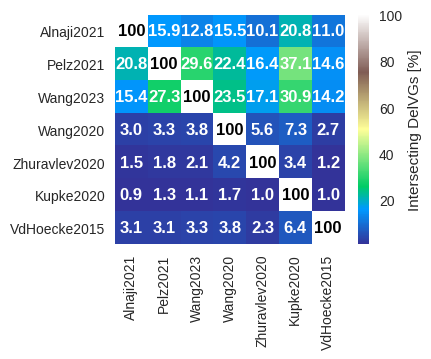

In [54]:
def generate_overlap_matrix_plot(dfs: list, dfnames: list, name: str=""):
    '''
        plot a matrix that shows how big the overlap of DelVGs between the
        given datasets is.
        :param dfs: The list of DataFrames containing the data, preprocessed
            with sequence_df(df)
        :param dfnames: The names associated with each DataFrame in `dfs`
        :param name: string to define result and name of resultsfile

        :return: None
    '''
    plt.figure(figsize=(5, 4))
    plt.rc("font", size=20)
    # initialize an empty matrix
    matrix_size = len(dfs)
    matrix = [[0] * matrix_size for _ in range(matrix_size)]
    # calculate the differences and populate the matrix
    for i in range(matrix_size):
        set1 = set(dfs[i]["key"])
        for j in range(matrix_size):
            set2 = set(dfs[j]["key"])
            matrix[i][j] = len(set1 & set2) / len(set2) * 100
            if i == j:
                text = f"{matrix[i][j]:.0f}"
                color = "black"
            else:
                text = f"{matrix[i][j]:.1f}"
                color = "white"
            plt.annotate(text, xy=(j, i), color=color, ha='center', va='center', fontsize=12, fontweight='bold')

    plt.imshow(matrix, cmap="terrain", interpolation="nearest")
    plt.colorbar(fraction=0.046, pad=0.04, label="Intersecting DelVGs [%]")
    plt.xticks(np.arange(len(dfnames)), dfnames, rotation=90)
    plt.yticks(np.arange(len(dfnames)), dfnames)
    plt.tight_layout()
    plt.grid(False)

    if name != "":
        filename = f"{name}_intersection_matrix_PR8.png"
    else:
        filename = "intersection_matrix_PR8.png"
    save_path = os.path.join(RESULTSPATH, "intersection_analysis")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, filename))
    plt.show()
    plt.close()

generate_overlap_matrix_plot(dfs, dfnames)

Get max overlapping candidates

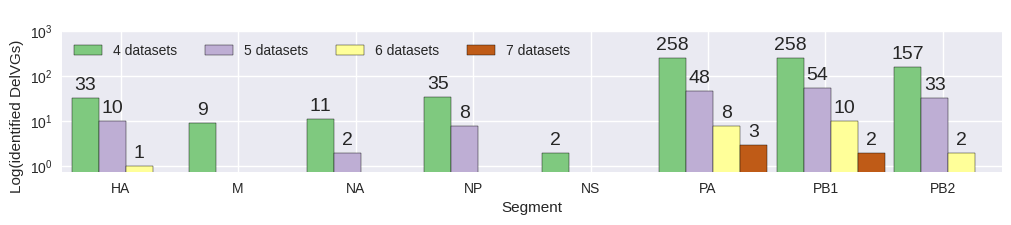

In [55]:
def generate_max_overlap_candidates(dfs: list)-> pd.DataFrame:
    '''
        analyses for all DelVGs in the given datasets how often they occur in
        the datasets and resturns this in a DataFrame.
        :param dfs: The list of DataFrames containing the data, preprocessed
            with sequence_df(df)
        :param thresh: threshold for occurrence of a DelVG to be considered

        :return: DataFrame with all DelVGs above or equal to given threshold
    '''
    all_candidates = list()
    for df in dfs:
        all_candidates.extend(df["key"].tolist())
    candidate_counts = Counter(all_candidates)
    # at least half of the datasets (7)
    thresh = 4
    candidates = list()
    counts = list()
    for cand, count in candidate_counts.items():
        if count >= thresh:
            candidates.append(cand)
            counts.append(count)
            
    count_df = pd.DataFrame(dict({"DI": candidates, "no.datasets": counts}))
    count_df[["Segment", "Start", "End"]] = count_df["DI"].str.split("_", expand=True)
    return count_df

def barplot_counts(count_df):
    count_table = count_df.groupby(["Segment", "no.datasets"]).size().reset_index(name='count')
    zero_df = pd.DataFrame({"Segment": ["HA", "M", "M", "M", "NA", "NA", "NP", "NP", "NS", "NS", "NS", "PB2"],
                            "no.datasets": [7, 5, 6, 7, 6, 7, 6, 7, 5, 6, 7, 7],
                            "count": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})
    comb_df = pd.concat([count_table, zero_df])
    comb_df = comb_df.sort_values(by=['Segment', 'no.datasets'])

    x = np.arange(8)
    width = 0.23
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 2))

    colors = [cm(1.*i/8) for i in [0, 1, 3, 6]]
    for i in [4, 5, 6, 7]:
        data = comb_df[comb_df['no.datasets'] == i]['count'].to_list()
        offset = width * multiplier - 0.3
        rects = ax.bar(x + offset, data, width, label=f'{i} datasets', color=colors[i-4], edgecolor="black")
        ax.bar_label(rects, padding=3, fontsize=14)
        multiplier += 1
    
    ax.set_xticks(x, comb_df['Segment'].unique())
    ax.set_yscale('log')
    ax.set_ylim(top=1000)
    ax.set_xlim(left=-0.5, right=7.5)
    ax.set_xlabel('Segment')
    ax.set_ylabel('Log(identified DelVGs)       ')
    plt.legend(loc='upper left', ncol=4)

    filename = "candidate_counts_bar.png"
    save_path = os.path.join(RESULTSPATH, "intersection_analysis")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, filename))
    plt.show()
    plt.close()

count_df = generate_max_overlap_candidates(dfs)
barplot_counts(count_df)

Calculate pelz labels for each candidate and percentiles

In [56]:
def assign_label(row):
    '''
    
    '''
    start = row["VB3-Saat"]
    end = row["VB3-48"]
    t1 = "de novo " if start == 0 else ""
    t2 = "gain" if start < end else "loss"
    return f"{t1}{t2}"

for accnum in ACCNUMDICT["Pelz2021"].keys():
    t_df = load_single_dataset("Pelz2021", accnum, SEGMENT_DICTS["PR8"])
    t_df["DI"] = t_df["Segment"] + "_" + t_df["Start"].map(str) + "_" + t_df["End"].map(str)
    if accnum == "SRR15084925":
        t_df = t_df.rename(columns={'NGS_read_count': "VB3-Saat"})
        pelz_data = t_df
    elif accnum == "SRR15084909":
        t_df = t_df.rename(columns={'NGS_read_count': "VB3-48"})
        pelz_data = pd.merge(pelz_data, t_df[['DI', 'VB3-48']], on='DI', how='outer')
    else:
        pelz_data = pd.merge(pelz_data, t_df['DI'], on='DI', how='outer')

drop = ['Segment', 'Start', 'End']
pelz_data = pelz_data.drop(columns=drop)
pelz_data = pelz_data.fillna(0)
pelz_data['label'] = pelz_data.apply(assign_label, axis=1)
count_df = pd.merge(count_df, pelz_data[['DI', 'label']], on='DI', how='left')

for df, dfname in zip(dfs, dfnames):
    perc_list = list()
    for c in count_df['DI'].to_list():
        ngs_count = df[df["key"] == c]["NGS_read_count"]
        if ngs_count.empty:
            percentile = 0.0
        else:
            percentile = percentileofscore(df["NGS_read_count"], ngs_count.values[0])
        perc_list.append(percentile)
    count_df[dfname] = perc_list


## Elaborate PB2 candidates


In [57]:
def score_sum(row):
    s = row.iloc[6:13].sum()
    return s
def score_mean(row):
    values = row.iloc[6:13].to_list()
    non_zero_values = [x for x in values if x != 0]
    s = sum(non_zero_values) / len(non_zero_values)
    return s

res_df = count_df
res_df['score_sum'] = res_df.apply(score_sum, axis=1)
res_df['score_mean'] = res_df.apply(score_mean, axis=1)

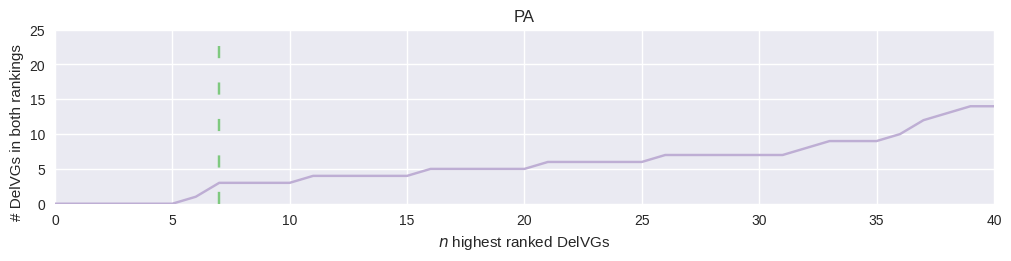

              DI  no.datasets label   score_sum  score_mean
158  PA_138_2063            5  loss  481.870687   96.374137
159   PA_139_169            5  gain  485.031816   97.006363
209  PA_167_1990            6  gain  573.162805   95.527134


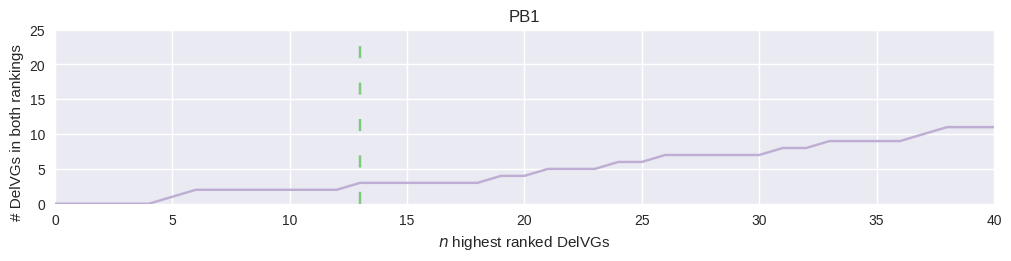

               DI  no.datasets label   score_sum  score_mean
378     PB1_54_98            5  loss  473.126947   94.625389
416  PB1_113_2165            5  gain  483.470580   96.694116
527  PB1_200_2072            5  gain  482.835926   96.567185


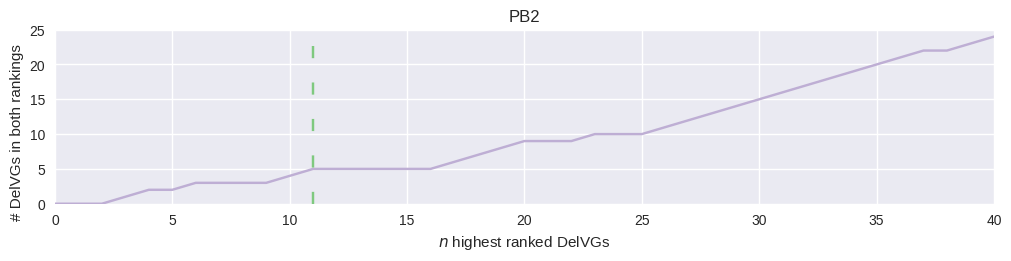

               DI  no.datasets         label   score_sum  score_mean
625  PB2_109_2152            5          gain  470.092937   94.018587
674  PB2_163_2139            5  de novo gain  462.828883   92.565777
675  PB2_163_2152            6  de novo gain  567.638954   94.606492
691  PB2_177_2141            5  de novo loss  461.995961   92.399192
708  PB2_191_2048            5  de novo gain  467.717824   93.543565


In [58]:
def evaluate_per_segment(df, segment):
    s_df = df[df['Segment'] == segment]
    sum_sort = s_df.sort_values(by='score_sum', ascending=False)['DI'].to_list()
    mean_sort = s_df.sort_values(by='score_mean', ascending=False)['DI'].to_list()

    sizes = range(41)
    i_s = list()
    for size in sizes:
        top_sum = sum_sort[:size]
        top_mean = mean_sort[:size]
        intersection = set(top_sum) & set(top_mean)
        i_s.append(len(intersection))

    fig, ax = plt.subplots(layout='constrained', figsize=(10, 2.5))

    ax.plot(sizes, i_s, c=cm(1/8))
    if segment == 'PA':
        x = 7
    elif segment == 'PB1':
        x = 13
    elif segment == 'PB2':
        x = 11
    
    ax.axvline(x=x, color=cm(0), linestyle=(0, (5, 10)))
    ax.set_xlabel("$\it{n}$ highest ranked DelVGs")
    ax.set_ylabel("# DelVGs in both rankings       ")
    ax.set_title(segment)
    ax.set_ylim(top=25, bottom=0)
    ax.set_xlim(left=0, right=40)

    filename = f"score_intersection_{segment}.png"
    save_path = os.path.join(RESULTSPATH, "intersection_analysis")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, filename))
    plt.show()
    plt.close()

    intersection = set(sum_sort[:x]) & set(mean_sort[:x])
    final_cands = res_df[res_df['DI'].isin(intersection)]
    print(final_cands[["DI", "no.datasets", "label", "score_sum", "score_mean"]])

for seg in ['PA', 'PB1', 'PB2']:
    evaluate_per_segment(res_df, seg)

## validation with random data

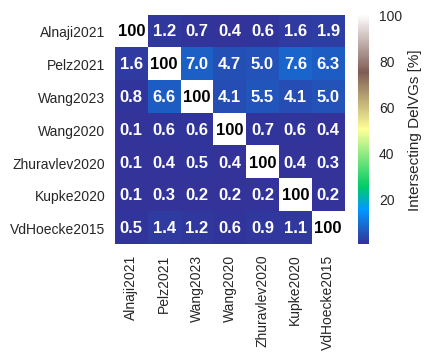

In [59]:
sampl_dfs = list()
for df, dfname in zip(dfs, dfnames):
    f = os.path.join(DATAPATH, "random_sampled", f"{dfname}_1.csv")
    if not os.path.exists(f):
        for seg in SEGMENTS:
            s_df = df.loc[df["Segment"] == seg]
            n = s_df.shape[0]
            if n == 0:
                continue
            seq = get_sequence(strain, seg)
            start = int(s_df["Start"].mean())
            end = int(s_df["End"].mean())
            s = (max(start-200, 50), start+200)
            e = (end-200, min(end+200, len(seq)-50))
            if not (s[1] < e[0]):
                continue
            #skip if there is no range given
            #this would lead to oversampling of a single position
            if s[0] == s[1] or e[0] == e[1]:
                continue
            if "samp_df" in locals():
                temp_df = generate_sampling_data(seq, s, e, n)
                temp_df["Segment"] = seg
                samp_df = pd.concat([samp_df, temp_df], ignore_index=True)
            else:
                samp_df = generate_sampling_data(seq, s, e, n)
                samp_df["Segment"] = seg
        samp_df["NGS_read_count"] = 1
        samp_df = preprocess(strain, samp_df, 1)
        samp_df.to_csv(f)
    else:
        samp_df = pd.read_csv(f)
    sampl_dfs.append(samp_df)
    del samp_df
generate_overlap_matrix_plot(sampl_dfs, dfnames, name="testing")
count_df = generate_max_overlap_candidates(sampl_dfs)

Analyze high pot. candidates

In [60]:
sel_cands = list(["PA_138_2063", "PA_139_169", "PA_167_1990", "PB1_54_98", "PB1_113_2165", "PB1_200_2072", "PB2_109_2152", "PB2_163_2139", "PB2_163_2152", "PB2_177_2141", "PB2_191_2048"])

df = pd.DataFrame({"key": sel_cands})
df["Start"] = df.apply(lambda row: int(row["key"].split("_")[1]), axis=1)
df["End"] = df.apply(lambda row: int(row["key"].split("_")[2]), axis=1)
df["Segment"] = df.apply(lambda row: row["key"].split("_")[0], axis=1)

# length
def calc_length(r):
    full_seq_len = get_seq_len("PR8", r["Segment"])
    del_seq_len = len(get_deleted_sequence(r["key"], "PR8"))
    return full_seq_len - del_seq_len
df["length"] = df.apply(calc_length, axis=1)

# deletion shift
def get_shift(r):
    del_seq_len = len(get_deleted_sequence(r["key"], "PR8"))
    shift = del_seq_len % 3
    if shift == 1:
        shift = "+1"
    elif shift == 2:
        shift = "-1"
    return shift
df["shift"] = df.apply(get_shift, axis=1)

# direct repeats
def dir_rep_wrap(r):
    seq = get_sequence("PR8", r["Segment"])
    s = r["Start"]
    e = r["End"]
    w_len = 5
    l, _ = calculate_direct_repeat(seq, s, e, w_len)
    return l
df["dir_rep"] = df.apply(dir_rep_wrap, axis=1)

# nucleotide pair
def get_nuc_pair_start(r):
    seq = get_sequence("PR8", r["Segment"])
    s = r["Start"]
    return seq[s-2:s]
def get_nuc_pair_end(r):
    seq = get_sequence("PR8", r["Segment"])
    e = r["End"]
    return seq[e-3:e-1]
df["nuc_pair_s"] = df.apply(get_nuc_pair_start, axis=1)
df["nuc_pair_e"] = df.apply(get_nuc_pair_end, axis=1)

# 5'3' diff
def get_5_3_diff(r):
    return r["Start"] - (get_seq_len("PR8", r["Segment"]) - r["End"])
df["5_3"] = df.apply(get_5_3_diff, axis=1)

# is in vivo available
wang_df = load_dataset("Wang2023")
wang_df["key"] = wang_df["Segment"] + "_" + wang_df["Start"].map(str) + "_" + wang_df["End"].map(str)
wang_delvgs = wang_df["key"].tolist()

df["Wang"] = df['key'].apply(lambda x: x in wang_delvgs)


print(df)

             key  Start   End Segment  length shift  dir_rep nuc_pair_s  \
0    PA_138_2063    138  2063      PA     309    +1        1         UA   
1     PA_139_169    139   169      PA    2204    -1        3         AU   
2    PA_167_1990    167  1990      PA     411    +1        2         UA   
3      PB1_54_98     54    98     PB1    2298    +1        2         UA   
4   PB1_113_2165    113  2165     PB1     290    -1        2         UA   
5   PB1_200_2072    200  2072     PB1     470    -1        2         AC   
6   PB2_109_2152    109  2152     PB2     299    -1        2         UA   
7   PB2_163_2139    163  2139     PB2     366    +1        2         UA   
8   PB2_163_2152    163  2152     PB2     353    -1        2         UA   
9   PB2_177_2141    177  2141     PB2     378    +1        3         UG   
10  PB2_191_2048    191  2048     PB2     485    -1        1         UA   

   nuc_pair_e   5_3  Wang  
0          GA   -32  True  
1          AU -1925  True  
2          UA  